## Auto MPG Data Set
- https://archive.ics.uci.edu/ml/datasets/Auto+MPG
- The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.
- This is a regression problem where we aim to predict the output of a continuous value, ie fuel efficiency.

## Steps perfomed in this SAS notebook:
- Importing Raw Data Files
- Check Data Types of Variables
- Check for Missing Data
- Handle Missing Values
- Check for Duplicate Entries
- Check for Outliers
- Check for Normal Distribution of Variables
- Handle Outliers using Multiple Regression Model
- Check Correlation between Variables
- Log Transformation
- Additional Visualizations
- Prediction (Multiple Linear Regression Model)

## Importing Raw Data Files

In [31]:
options nosource nonotes errors=0;

libname auto '/folders/myfolders/Project';

proc import Datafile= "~/Project/auto_mpg.csv"
    out= auto.original
    dbms=csv
    replace;
run;

*Ignore error in data import. It is beacuse of '?' values in the Horsepower variable;
proc print data= auto.original (obs=5);
run;

Obs,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
1,18,8,307,130,3504,12,70,1,chevrolet chevelle malibu
2,15,8,350,165,3693,11.5,70,1,buick skylark 320
3,18,8,318,150,3436,11,70,1,plymouth satellite
4,16,8,304,150,3433,12,70,1,amc rebel sst
5,17,8,302,140,3449,10.5,70,1,ford torino


## Check Data Types of Variables

In [2]:
*Check the variables type, length and formatting;
proc contents data= auto.original varname;
run;

*Check mean, minimum and maximum values of all numeric variables;
proc means data = auto.original;
run;

## Check for Missing Data

In [3]:
*Output shows 6 missing values in horsepower variable;

proc means data=auto.original n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,398 398 398 392 398 398 398 398,0 0 0 6 0 0 0 0


In [4]:
*Output shows no missing values in character variables;

proc format;
    value $car
    ' ' = 'Missing'
    other = 'Non Missing';

proc freq data=auto.original;
    tables _character_ /nocum missing;
    format _character_ $car.;
run;

car_name,Frequency,Percent
Non Missing,398,100.00


In [5]:
*Print the row number for which data is missing in horsepower;

data _null_;
    set auto.original;
    file print;
    if horsepower eq '?' then put
    _n_= horsepower=;
run;

## Handle Missing Values

In [6]:
*Replace missing 6 values in horsepower with the mean value of 104.47;
proc means data=auto.original mean median;
    var horsepower;
run;

In [7]:
*Replacing missing values with mean value of horsepower variable;

data auto.updated;
    set auto.original;
    if horsepower eq '?' then horsepower=104.47;
run;

* Re-check if there are any missing values now;
proc means data=auto.updated n nmiss;
    var horsepower;
run;

## Check for Duplicate Entries

In [8]:
*Log shows "0 duplicate observations were deleted". So all observations are unique;

options source notes errors=4;
    proc sort data=auto.updated out=temp_1 noduprecs;
    by mpg;
run;

## Check for Outliers

In [9]:
*Three different methods have been used here to detect the outliers;

*Method 1: Print outlier values 3 Standard Deviation away from the mean;
*Triming 5% values from the top and bottom of the data;

ods output TrimmedMeans=auto.trimmed (keep= Varname mean stdmean df);
proc univariate data = auto.updated trim=0.05 nextrobs=10;
run;
ods output close;

proc print data=auto.trimmed;
run;

Obs,VarName,Mean,StdMean,DF
1,acceleration,15.5198,0.1375,357
2,cylinders,5.4050,0.0942,357
3,displacement,187.3,5.6646,357
4,horsepower,101.7,1.9251,357
5,model_year,76.0112,0.2061,357
6,mpg,23.2229,0.4094,357
7,origin,1.5251,0.0447,357
8,weight,2937.2,45.1982,357


In [10]:
*Restructuring the dataset;

data temp_2;
set auto.updated;
array vars[*] _numeric_;
length VarName $ 32;
do i=1 to dim(vars);
    Varname=vname(vars[i]);
    Value=vars[i];
    output;
end;
keep Varname Value;
run;

proc print data=temp_2 (obs=10);
run;

Obs,VarName,Value
1,mpg,18
2,cylinders,8
3,displacement,307
4,horsepower,130
5,weight,3504
6,acceleration,12
7,model_year,70
8,origin,1
9,mpg,15
10,cylinders,8


In [11]:
*Checking values 3 Standard Deviation away from the mean;

proc sort data=temp_2;
    by varname;
run;

proc sort data=auto.trimmed;
    by varname;
run;

data auto.outlier;
merge temp_2 auto.trimmed;
by varname;
std_dev=stdmean*sqrt(df+1);
length Reason $12.;
if value lt mean-3*std_dev then do;
    reason='Low';
    output;
end;
else if value gt mean+3*std_dev then do;
    reason='High';
    output;
end;
run;

* Print the outlier values and the reason;
proc print data=auto.outlier;
    var varname value reason;
run;

Obs,VarName,Value,Reason
1,acceleration,23.5,High
2,acceleration,24.8,High
3,acceleration,23.7,High
4,acceleration,24.6,High
5,horsepower,220.0,High
6,horsepower,215.0,High
7,horsepower,225.0,High
8,horsepower,225.0,High
9,horsepower,215.0,High
10,horsepower,215.0,High



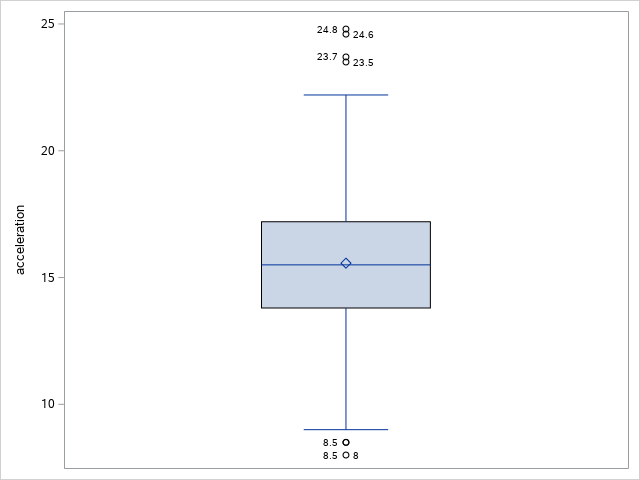

In [12]:
*Method 2: Check outliers using box plot method;

proc sgplot data= auto.updated;
    vbox acceleration /datalabel;
run;


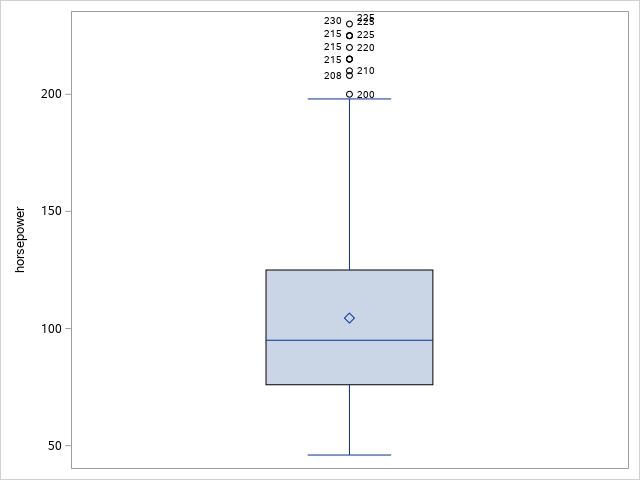

In [13]:
proc sgplot data= auto.updated;
    vbox horsepower /datalabel;
run;


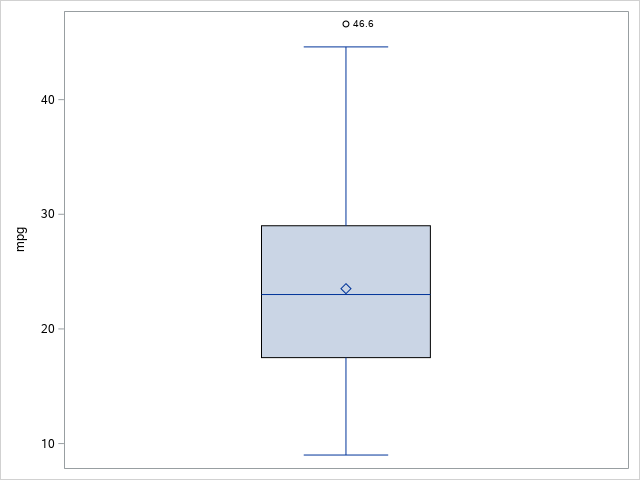

In [14]:
proc sgplot data= auto.updated;
    vbox mpg /datalabel;
run;


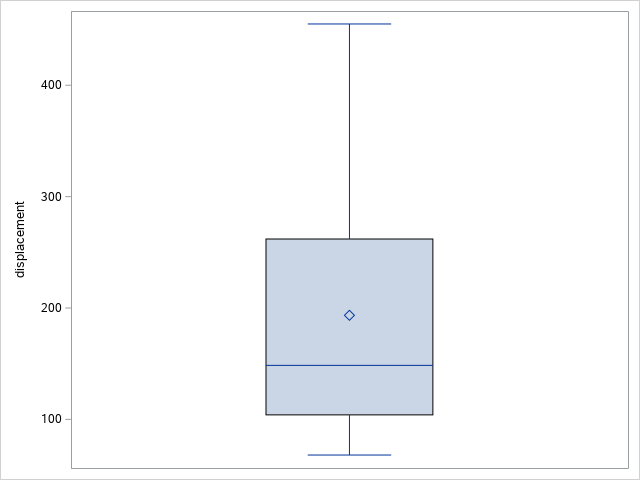

In [15]:
proc sgplot data= auto.updated;
    vbox displacement /datalabel;
run;


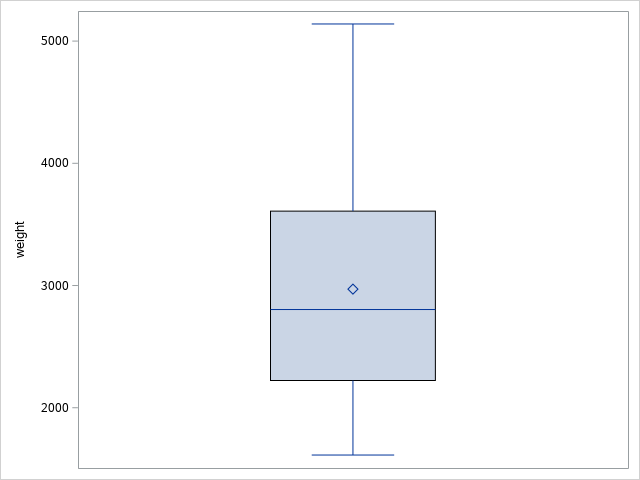

In [16]:
proc sgplot data= auto.updated;
    vbox weight /datalabel;
run;

In [17]:
*Method 3: Detect outliers via IQR method;

proc means data=auto.updated noprint;
    var acceleration horsepower mpg;
    output out=Tmpo (drop=_type_ _freq_)
    Q1=
    Q3=
    QRange= / autoname;
run;

data _null_;
    file print;
    set auto.updated(keep=acceleration horsepower mpg car_name);
    if _n_ = 1 then set Tmpo;
    if acceleration le acceleration_Q1 - 1.5*acceleration_QRange and not missing(acceleration) 
        or acceleration ge acceleration_Q3 + 1.5*acceleration_QRange then
        put "Possible Outlier for acceleration in " car_name "is " acceleration;
    else if horsepower le horsepower_Q1 - 1.5*horsepower_QRange and not missing(horsepower) 
        or horsepower ge horsepower_Q3 + 1.5*horsepower_QRange then
        put "Possible Outlier for horsepower in " car_name "is " horsepower;
    else if mpg le mpg_Q1 - 1.5*mpg_QRange and not missing(mpg) 
        or mpg ge mpg_Q3 + 1.5*mpg_QRange then
        put "Possible Outlier for mpg in " car_name "is " mpg;
run;

## Handle Outliers using Multiple Regression Model

In [18]:
*Only 18 observations have significant outlier values among total 398 observations;
*One way of handling outlier is to delete these 18 rows but as the total dataset is quite small so, we can't delete these rows;
*To handle the outliers, I am replacing the outliers found by IQR method with null value first and then;
*I am creating multiple regression models to predict those null values and; 
*thus, replace the values of the outliers with the predicted values in respective variables;


*Replacing the outliers found by IQR method with null value;

proc means data=auto.updated noprint;
    var acceleration horsepower mpg;
    output out=Tmpo (drop=_type_ _freq_)
    Q1=
    Q3=
    QRange= / autoname;
run;

data auto.outlier_null;
    set auto.updated;
    if _n_ = 1 then set Tmpo;
    if acceleration le acceleration_Q1 - 1.5*acceleration_QRange and not missing(acceleration) 
        or acceleration ge acceleration_Q3 + 1.5*acceleration_QRange then acceleration=.;
    else if horsepower le horsepower_Q1 - 1.5*horsepower_QRange and not missing(horsepower) 
        or horsepower ge horsepower_Q3 + 1.5*horsepower_QRange then horsepower=.;
    else if mpg le mpg_Q1 - 1.5*mpg_QRange and not missing(mpg) 
        or mpg ge mpg_Q3 + 1.5*mpg_QRange then mpg=.;
    
    keep mpg cylinders displacement horsepower weight acceleration model_year origin car_name;
run;

*10 null values in horsepower, 1 in mpg and 7 in accelaration;
proc means data=auto.outlier_null n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,397 398 398 388 398 391 398 398,1 0 0 10 0 7 0 0


In [19]:
*Model 1: Predict horsepower values;

proc reg data = auto.outlier_null noprint outest=betas;
    model horsepower = mpg cylinders displacement weight acceleration model_year origin;
run;
quit;

proc print data=betas noobs;
run;

data need_predictions;
    set auto.outlier_null;
    where horsepower = .;
run;

_MODEL_,_TYPE_,_DEPVAR_,_RMSE_,Intercept,mpg,cylinders,displacement,weight,acceleration,model_year,origin,horsepower
MODEL1,PARMS,horsepower,10.7732,121.338,-0.37394,0.59990,0.049125,0.022206,-4.38577,-0.32894,3.18011,-1


In [20]:
proc score data=need_predictions score=betas out=predictions type=parms;
    var mpg cylinders displacement weight acceleration model_year origin;
run;

data temp_3;
    set predictions;
    horsepower=Model1;
    drop model1;
run;

proc sort data=temp_3;
    by car_name weight;
run;

proc sort data=auto.outlier_null out=temp_4;
    by car_name weight;
run;

data temp_corrected;
    merge temp_4(in=l) temp_3(in=r);
    by car_name weight;
    if l=1;
run;

data auto.outlier_null;
    set temp_corrected;
run;

*Check if the horsepower values are updated. Nmiss is 0 for horsepower now;
proc means data=auto.outlier_null n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,397 398 398 398 398 391 398 398,1 0 0 0 0 7 0 0


In [21]:
*Replacing the only one outlier of mpg variable with the mean value;

data auto.outlier_null;
    set auto.outlier_null;
    if mpg eq . then mpg=23.5;
run;

*Check if the mpg values are updated. Nmiss is 0 for mpg now;
proc means data=auto.outlier_null n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,398 398 398 398 398 391 398 398,0 0 0 0 0 7 0 0


In [22]:
*Model 2: Predict acceleration values;

proc reg data = auto.outlier_null noprint outest=betas2;
    model acceleration = mpg cylinders displacement weight horsepower model_year origin;
run;
quit;

proc print data=betas2 noobs;
run;

data need_predictions2;
    set auto.outlier_null;
    where acceleration = .;
run;

_MODEL_,_TYPE_,_DEPVAR_,_RMSE_,Intercept,mpg,cylinders,displacement,weight,horsepower,model_year,origin,acceleration
MODEL1,PARMS,acceleration,1.56961,19.8988,-0.021623,0.15407,-0.014269,.003302349,-0.095911,-0.022818,-0.080295,-1


In [23]:
proc score data=need_predictions2 score=betas2 out=predictions2 type=parms;
    var mpg cylinders displacement weight horsepower model_year origin;
run;

data temp_5;
    set predictions2;
    acceleration=Model1;
    drop model1;
run;

proc sort data=temp_5;
    by car_name weight;
run;

proc sort data=auto.outlier_null out=temp_6;
    by car_name weight;
run;

data temp_corrected2;
    merge temp_6(in=l) temp_5(in=r);
    by car_name weight;
    if l=1;
run;

data auto.outlier_removed;
    set temp_corrected2;
run;

*Check if the acceleration values are updated. Nmiss is 0 for all variables now;
proc means data=auto.outlier_removed n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,398 398 398 398 398 398 398 398,0 0 0 0 0 0 0 0


## Check for Normal Distribution of Variables


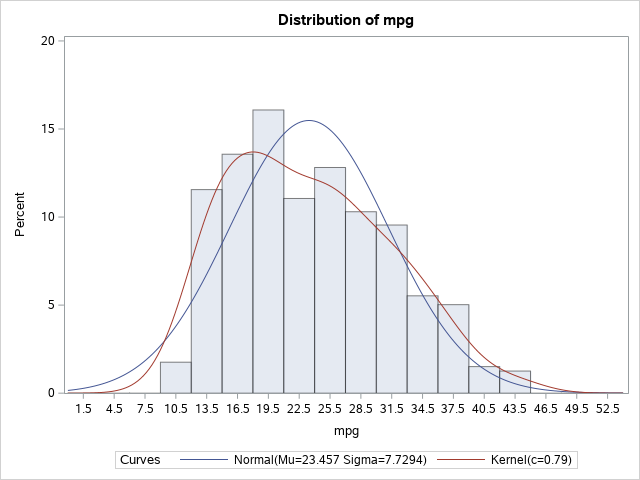
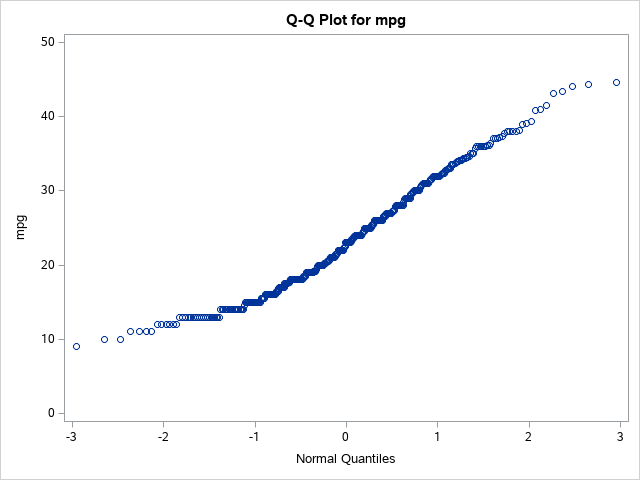
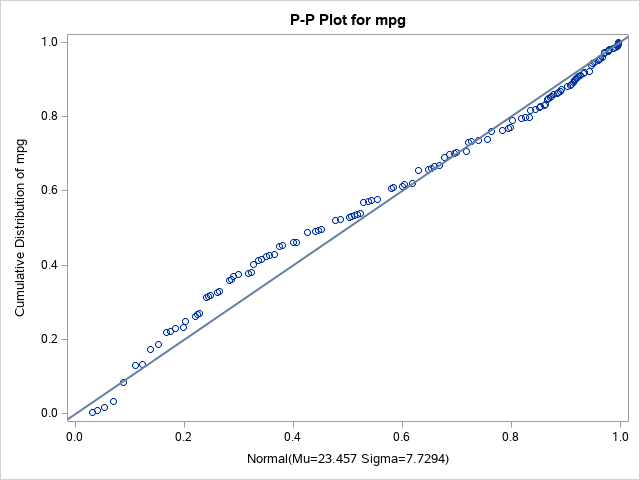
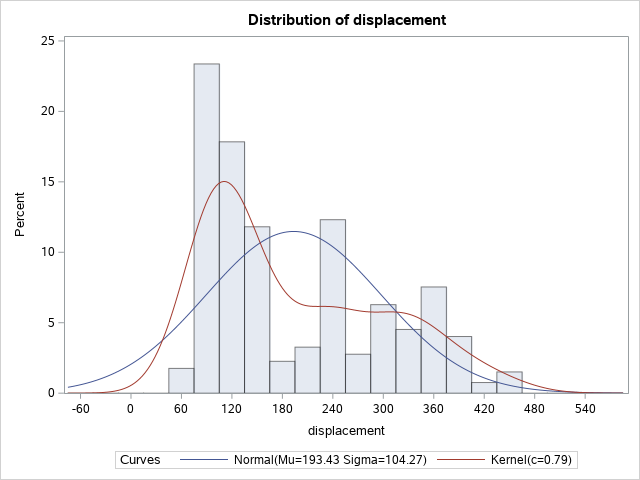
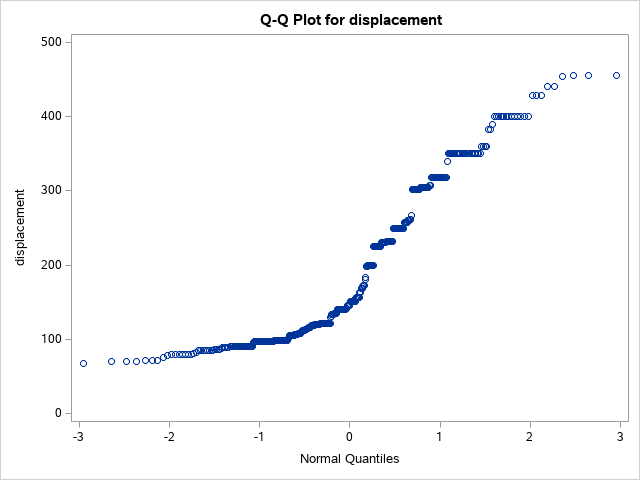
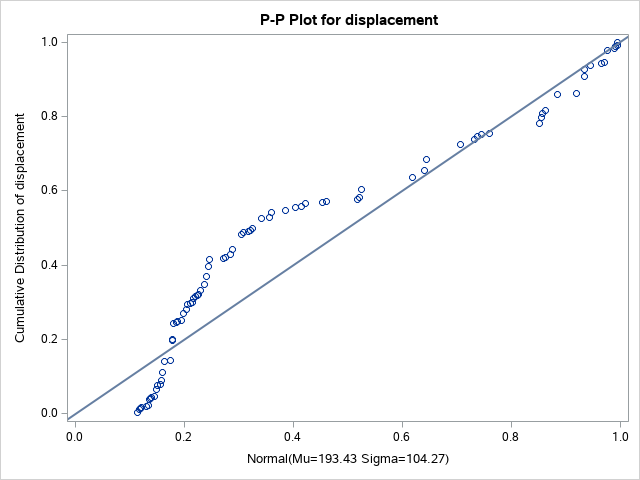
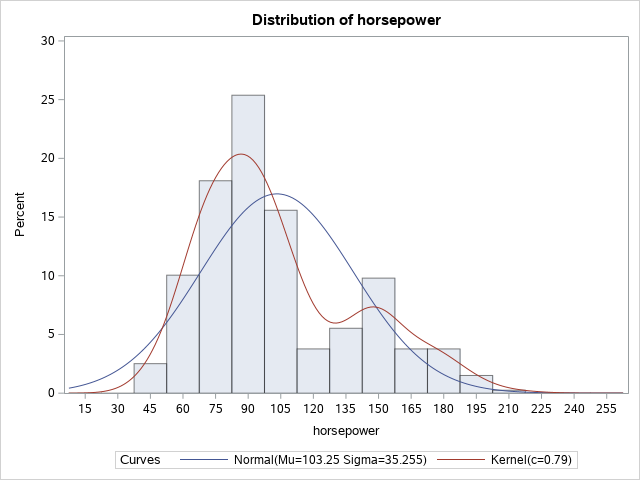
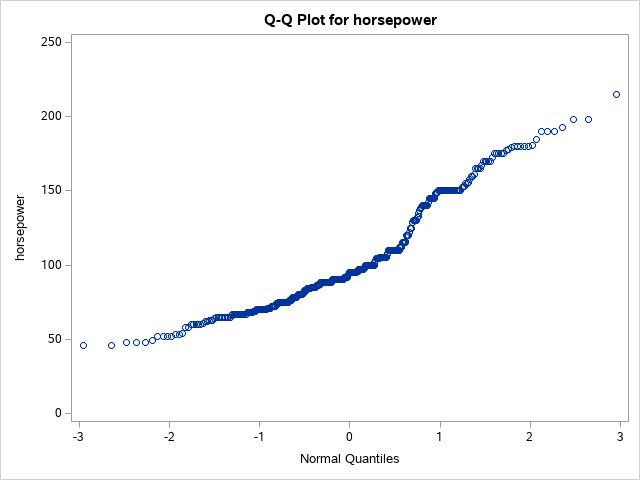
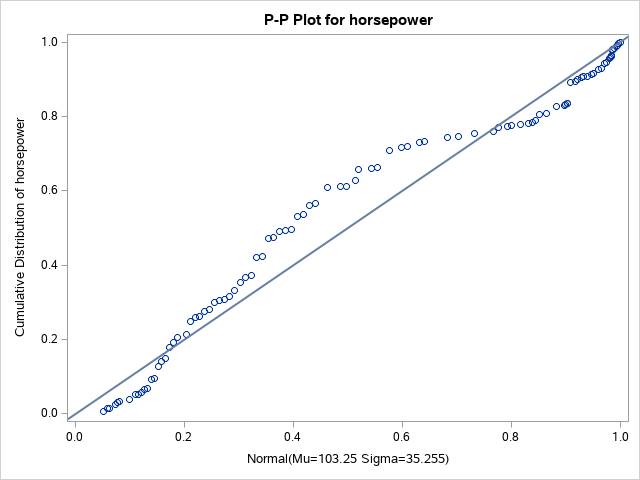
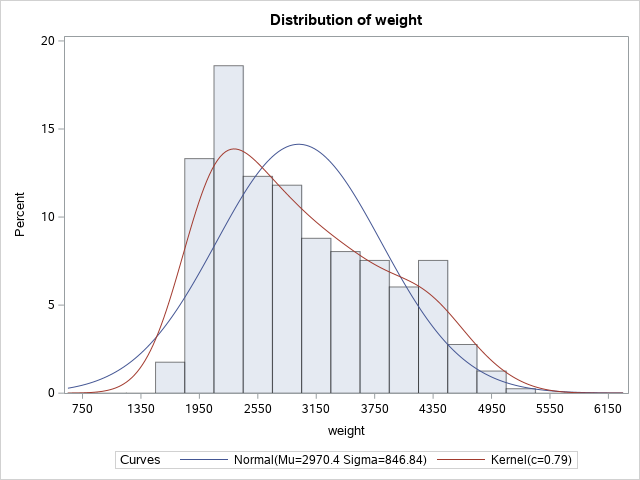
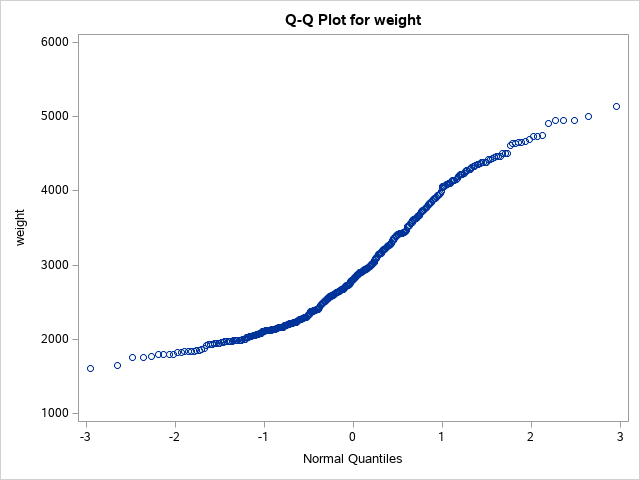
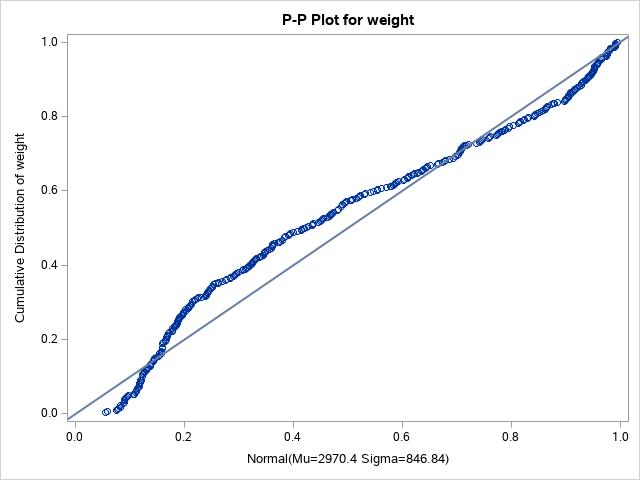
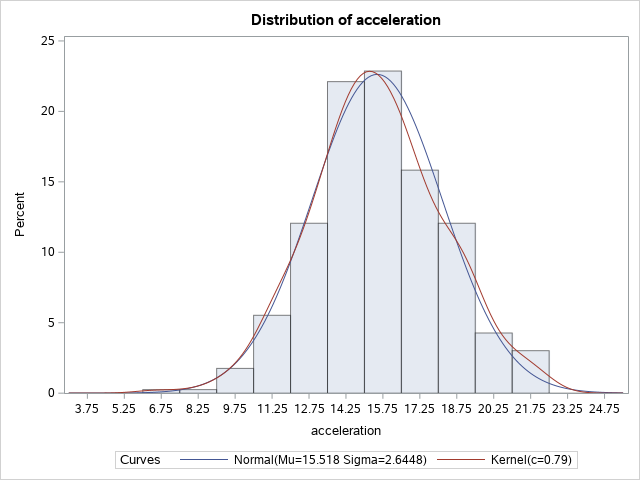
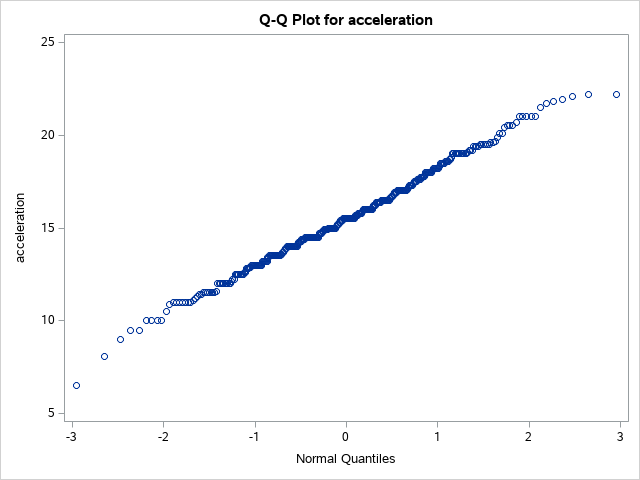
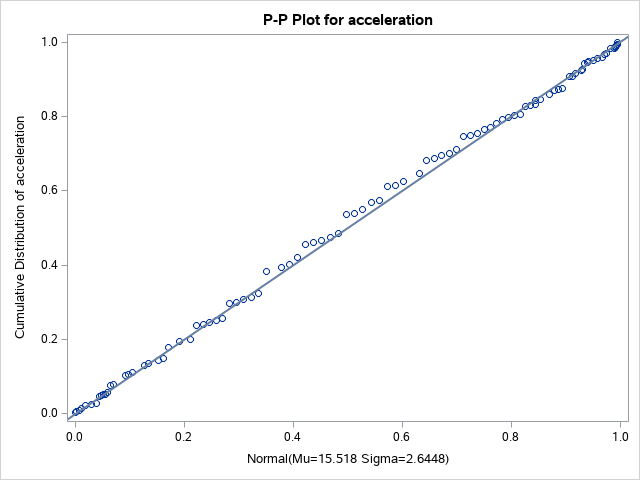

In [24]:
*Check histogram, Q-Q and probability plots for checking distribution of variables;

proc univariate data=auto.outlier_removed;
    var mpg displacement horsepower weight acceleration;
    ppplot;
    qqplot;
    histogram/ normal kernel;
run;

## Check Correlation between Variables

In [25]:
*Check Pearson correlation for linear variables and Spearman correlation for non-linear variables;

proc corr data=auto.outlier_removed pearson spearman plots=matrix(nvar=all histogram);
run;

## Log Transformation


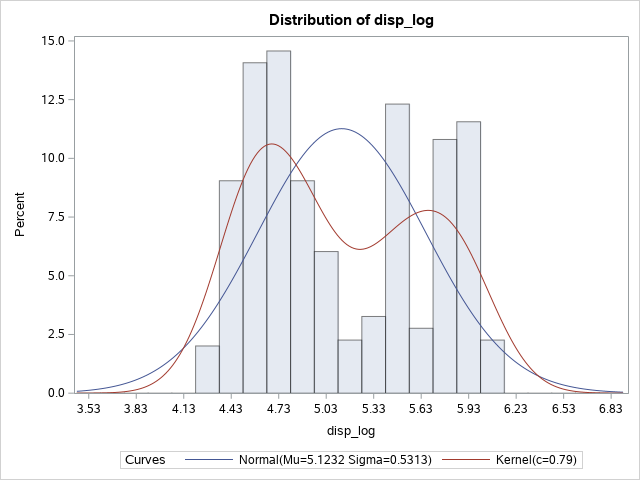
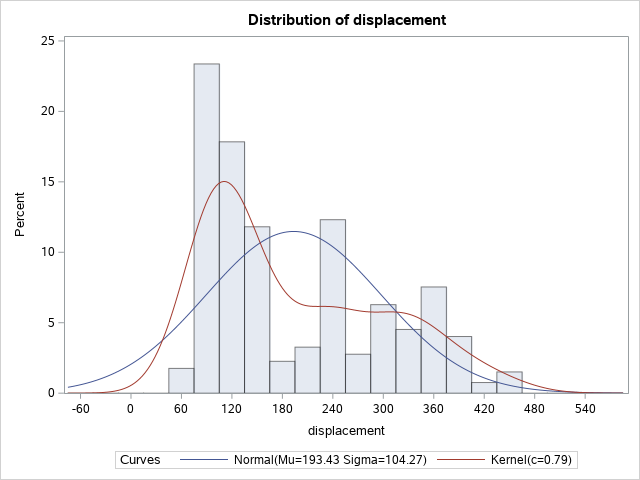

In [26]:
*The log transformation can be used to make highly skewed distributions less skewed;
*As displacement and mpg have skewed distribution so applying log transformation on these variables;

*Apply logarithmic transformation on displacement variable;

data auto.log_data;
    set auto.outlier_removed;
    disp_log = log(displacement);
run;

*Compare the new graphs;
ods select Histogram;
proc univariate data= auto.log_data noprint;
    var disp_log displacement;
    histogram / kernel normal;
run;


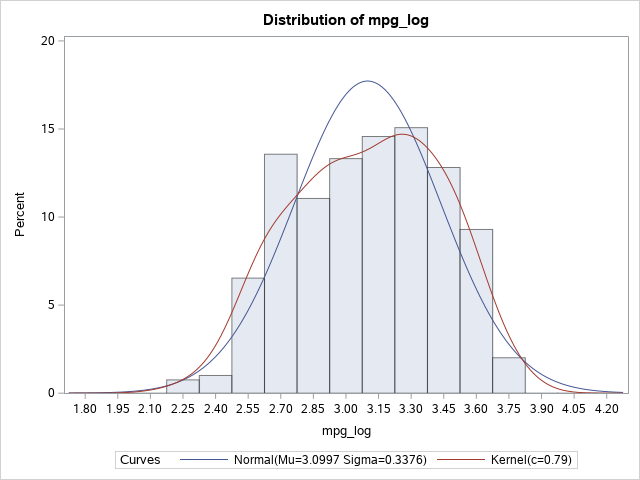
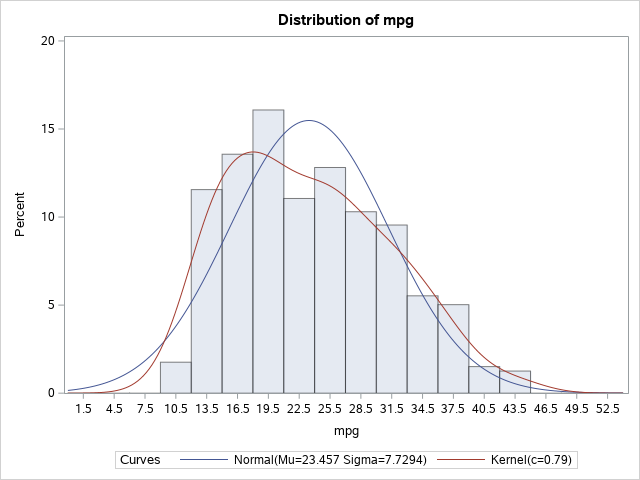

In [27]:
*Apply logarithmic transformation on mpg variable;

data auto.log_data;
    set auto.log_data;
    mpg_log = log(mpg);
run;

*Compare the new graphs;
ods select Histogram;
proc univariate data= auto.log_data noprint;
    var mpg_log mpg;
    histogram / kernel normal;
run;

## Additional Visualizations


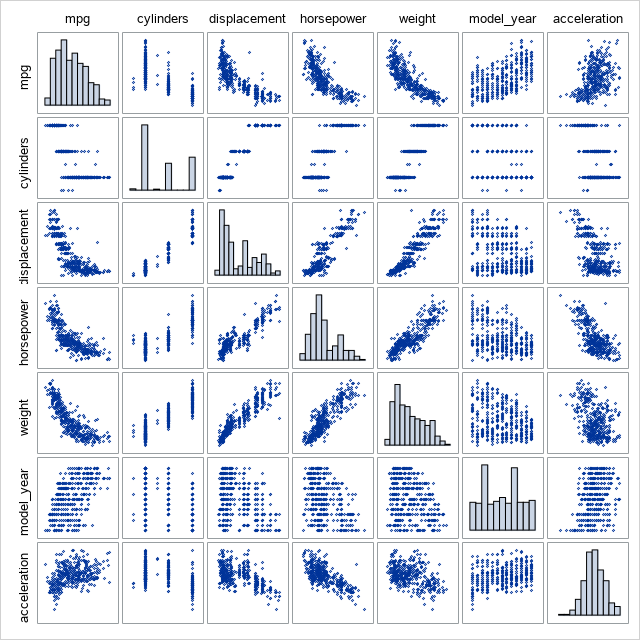

In [28]:
*Plot scatter plots to better visualize the relation between all the variables;

proc sgscatter data=auto.log_data;
    matrix mpg cylinders displacement horsepower weight model_year acceleration/ diagonal=(histogram);
run;


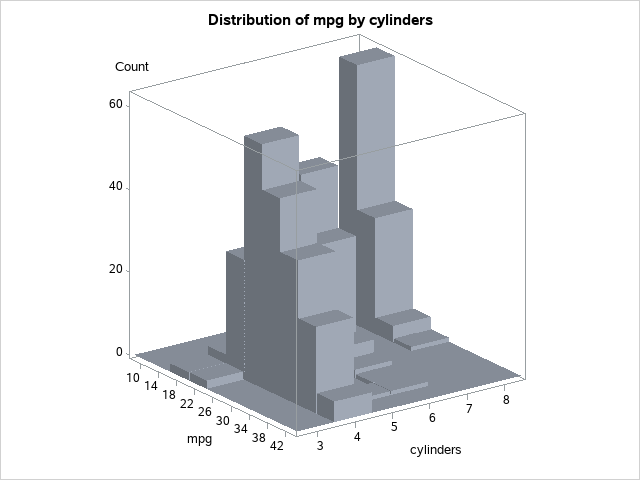
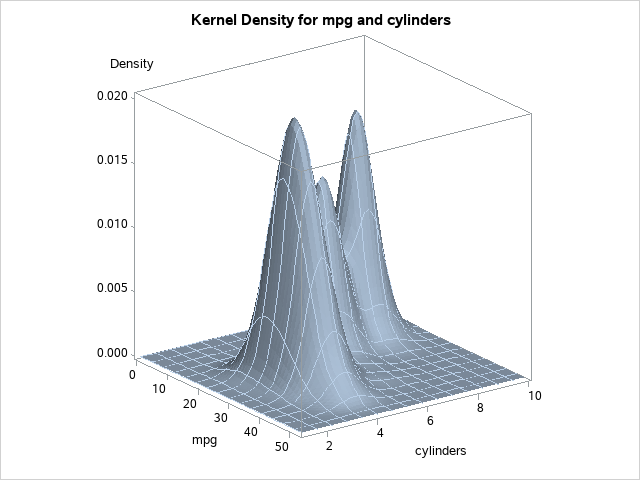
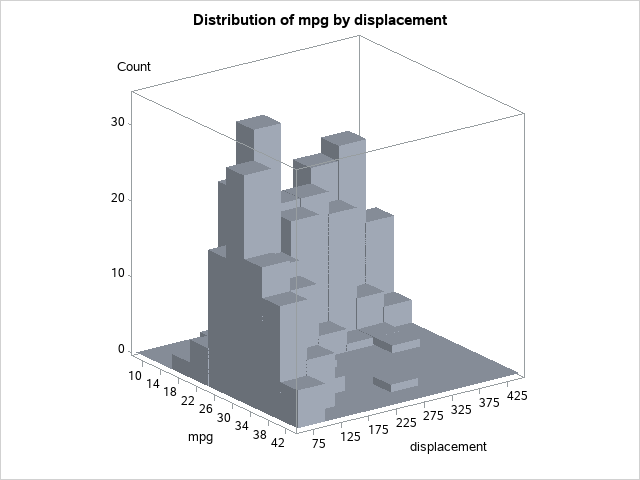
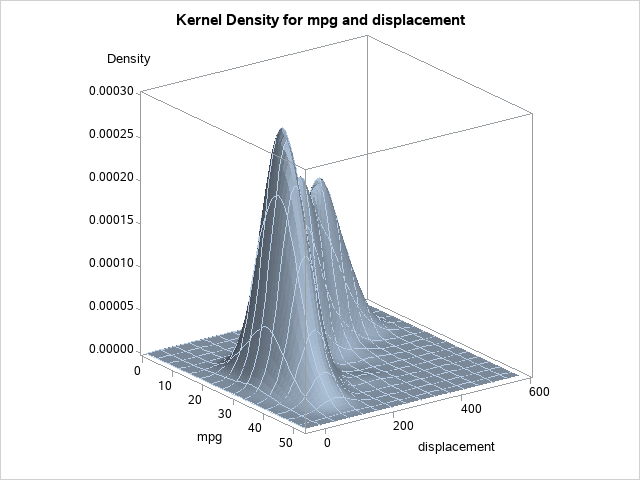
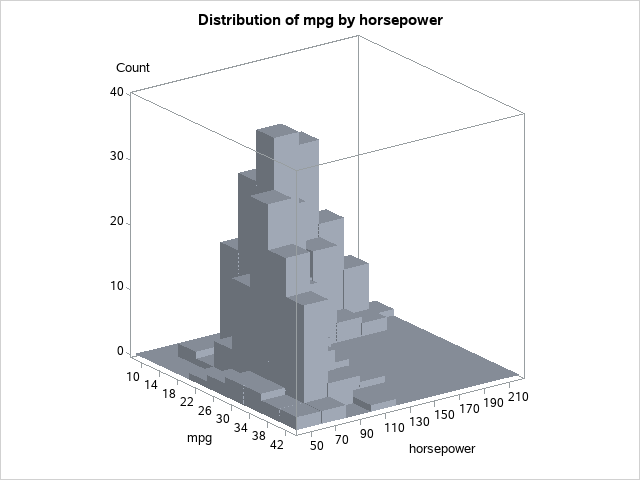
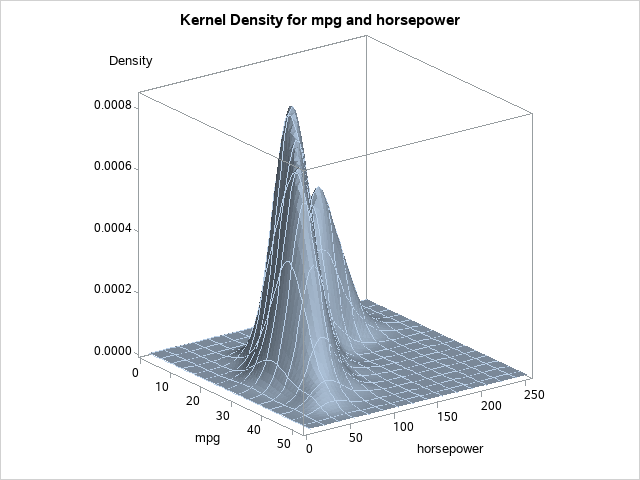
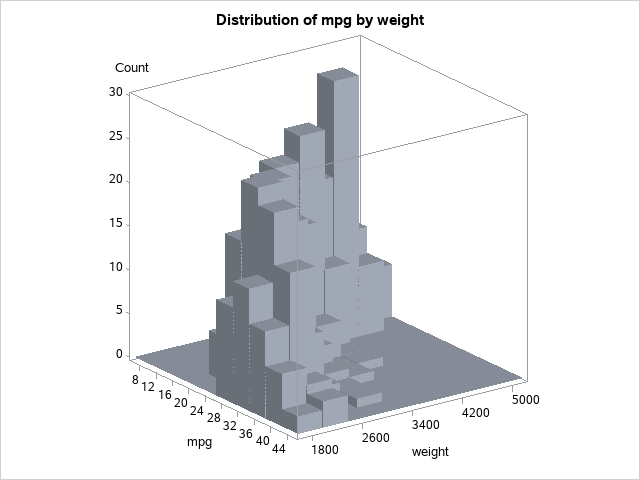
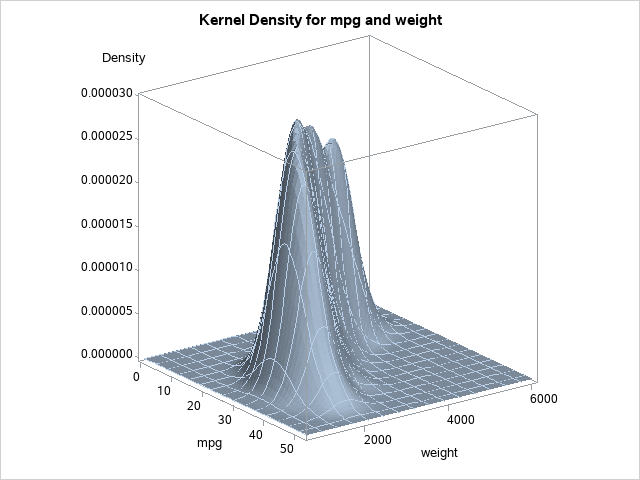
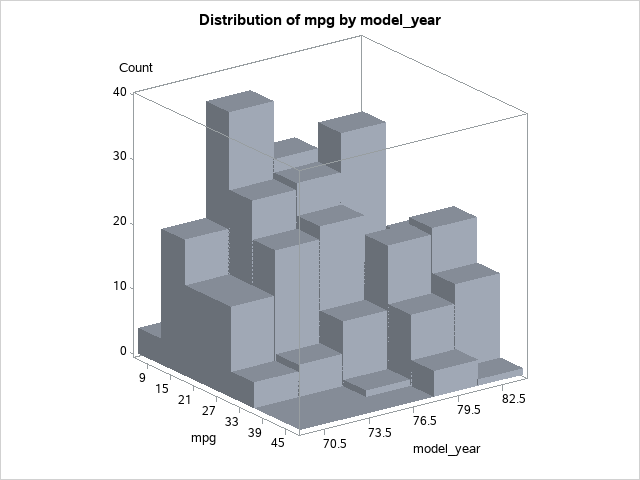
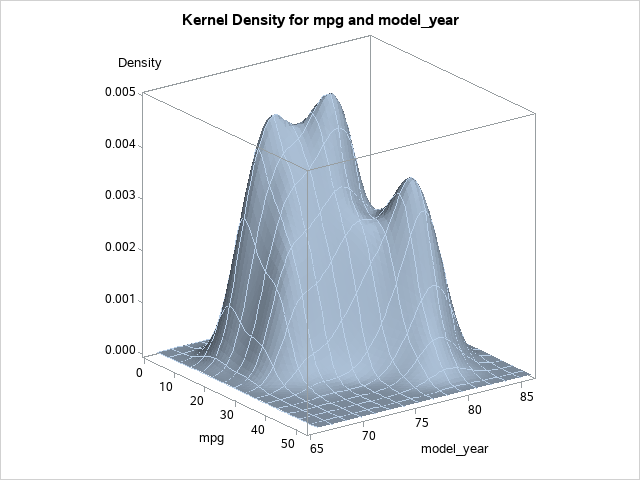
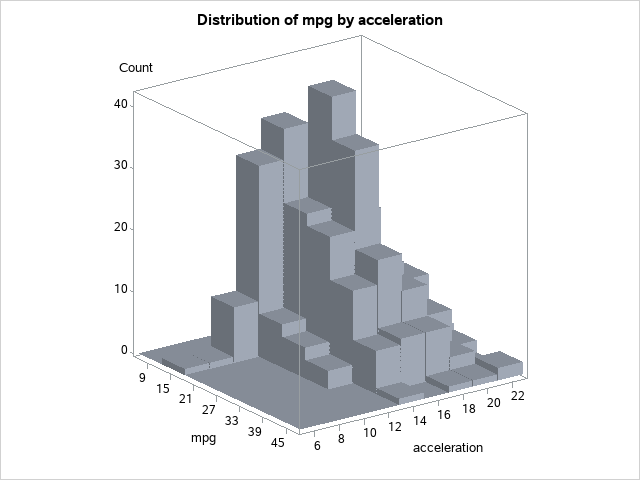
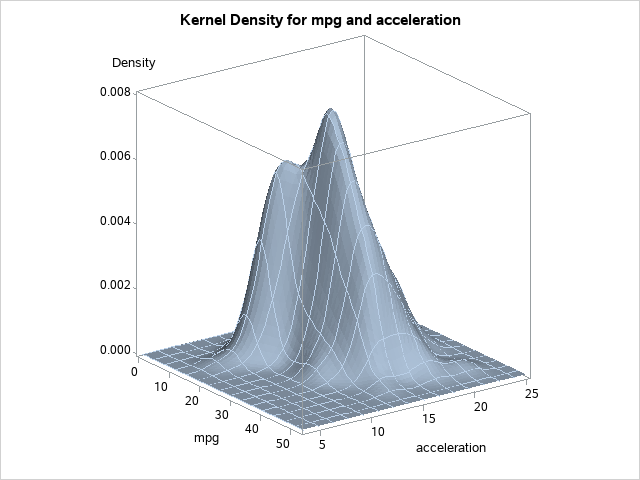

In [29]:
*Create 3D visualizations for checking the impact of different variables on mpg;

proc kde data=auto.log_data;
    bivar mpg cylinders / noprint plots = histogram surface;
    bivar mpg displacement / noprint plots = histogram surface;
    bivar mpg horsepower / noprint plots = histogram surface;
    bivar mpg weight / noprint plots = histogram surface;
    bivar mpg model_year / noprint plots = histogram surface;
    bivar mpg acceleration / noprint plots = histogram surface;
run;

## Prediction (Multiple Linear Regression Model)


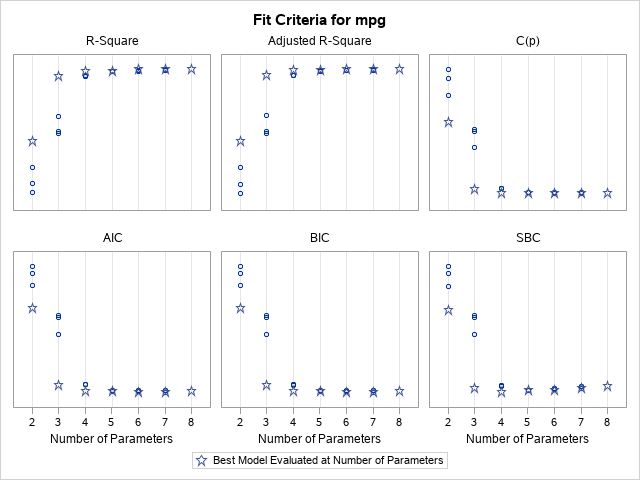
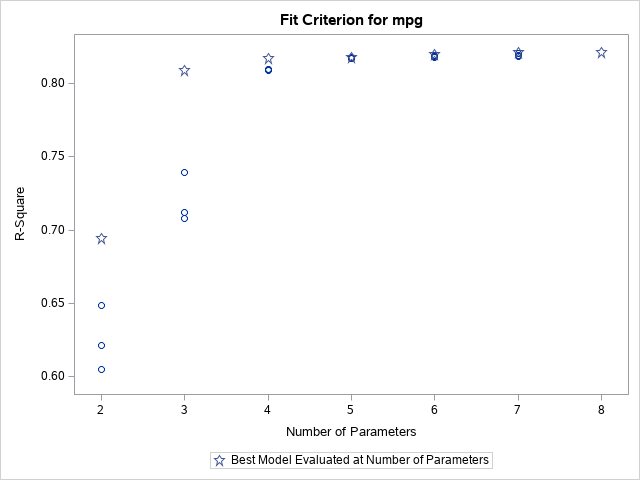
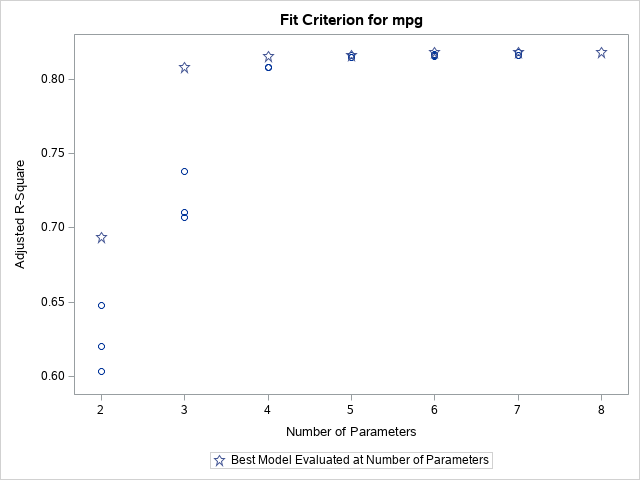
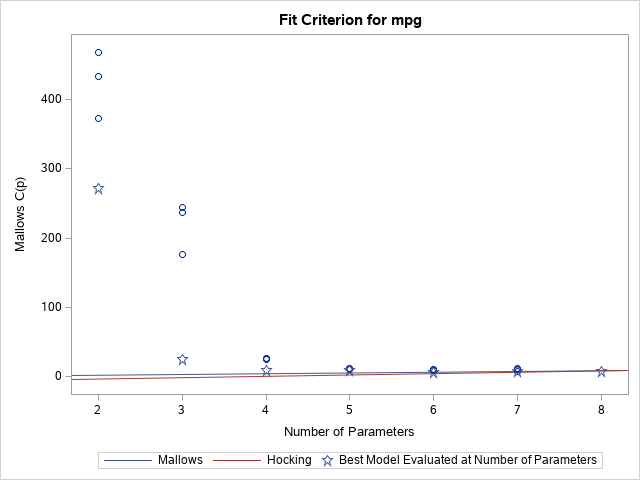
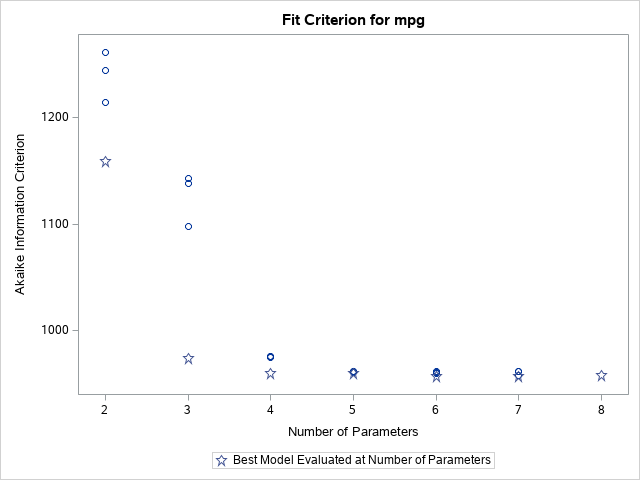
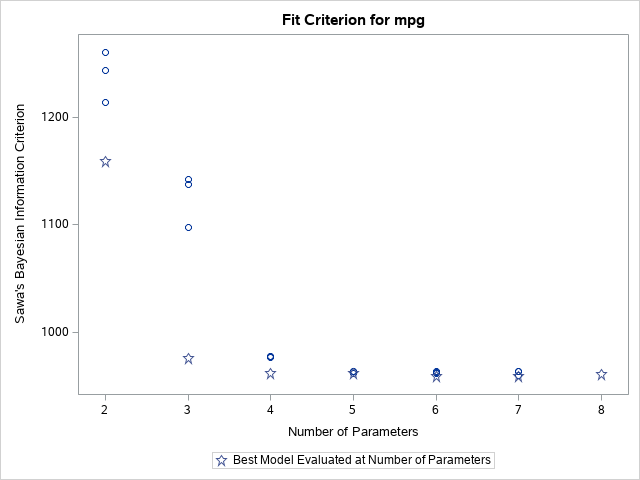
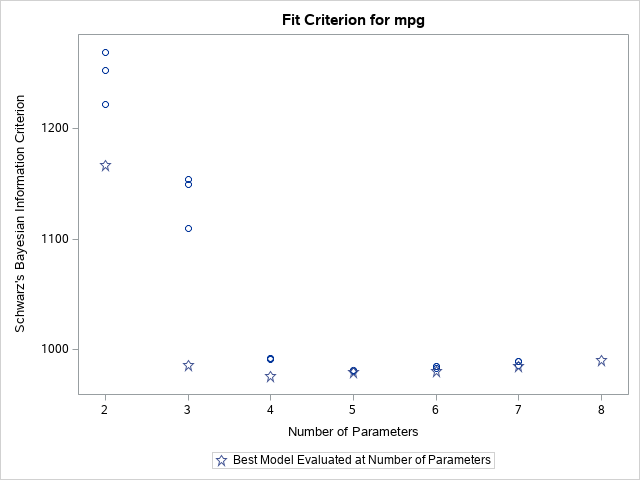
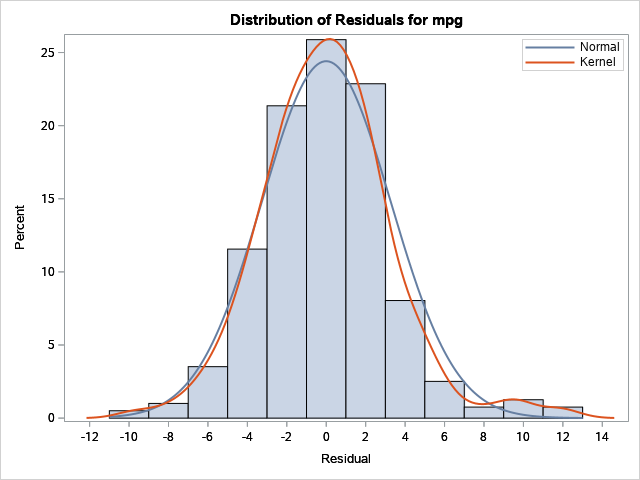
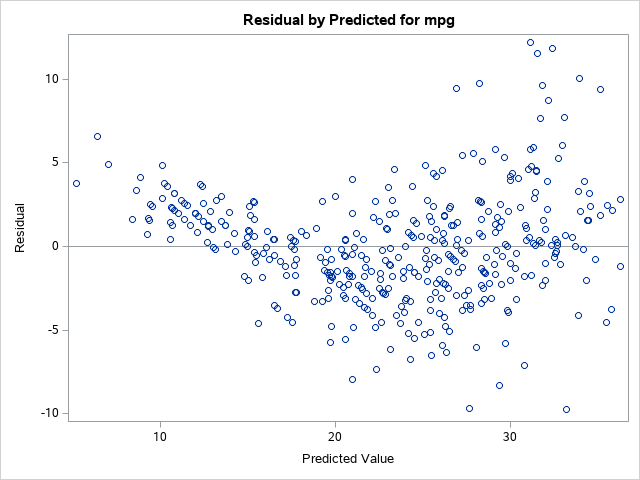
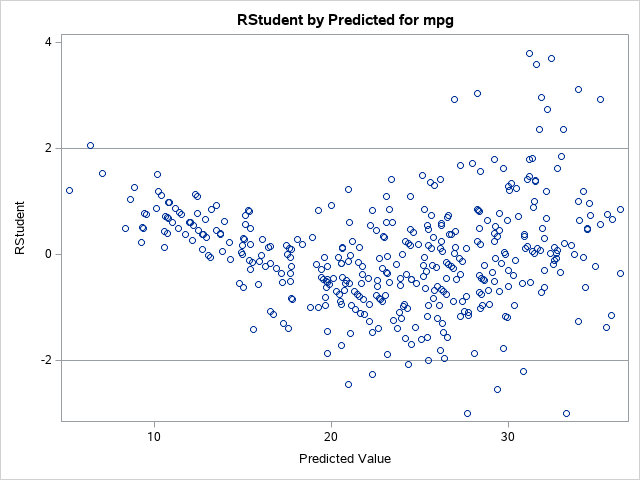
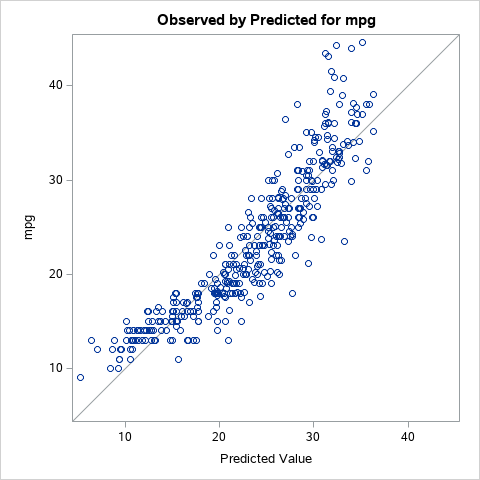
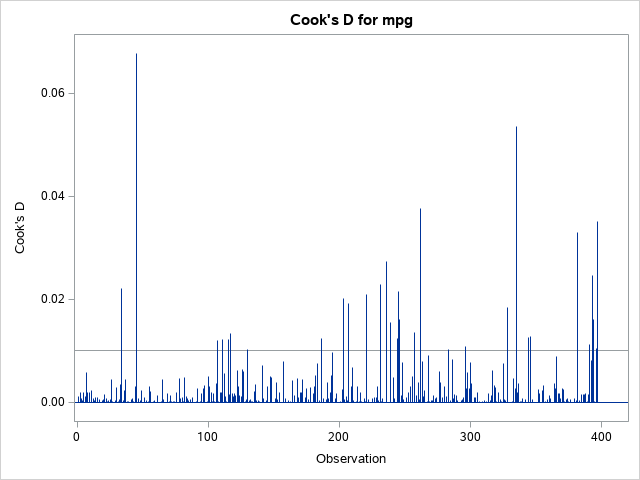
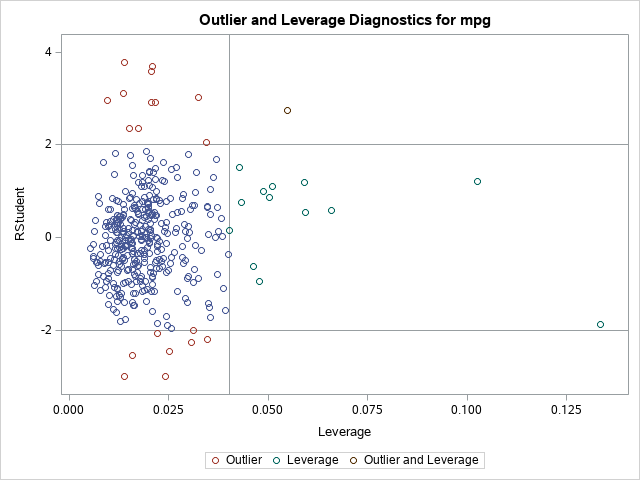
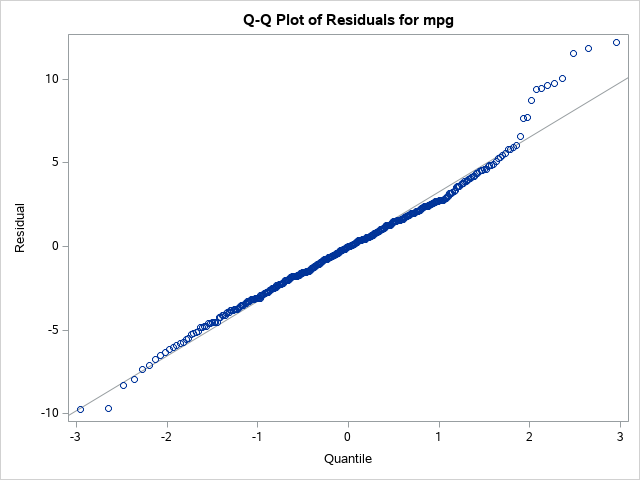
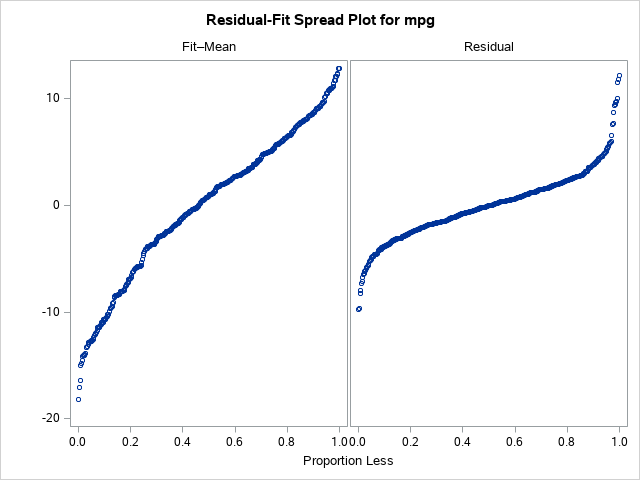
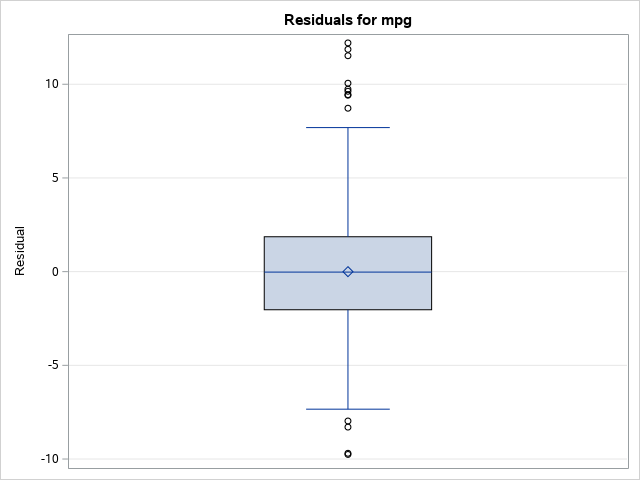
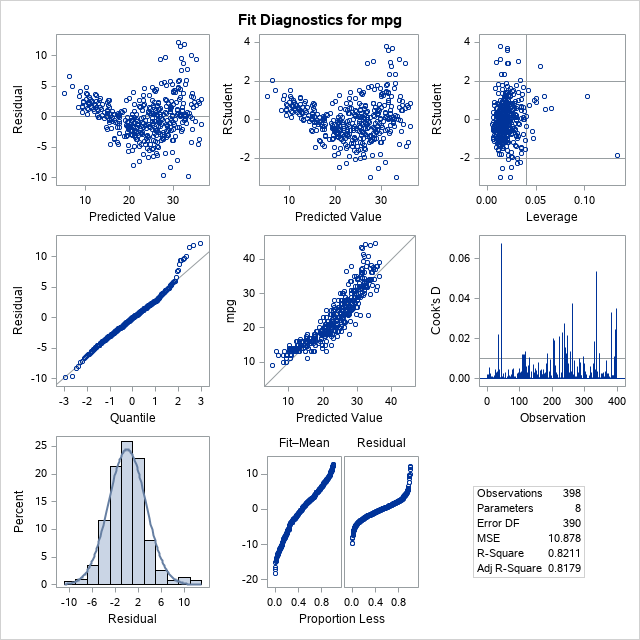
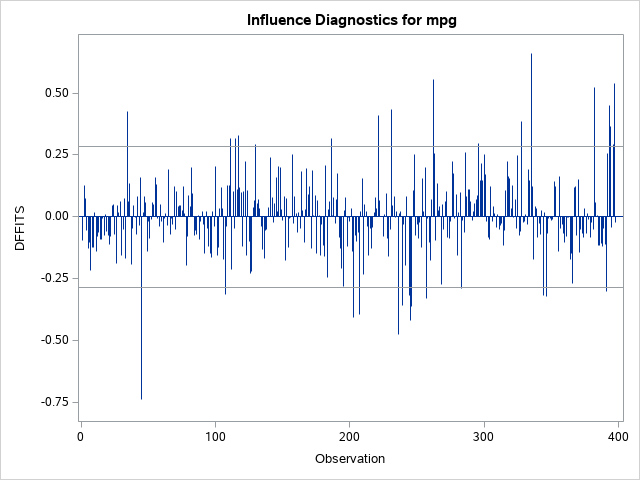
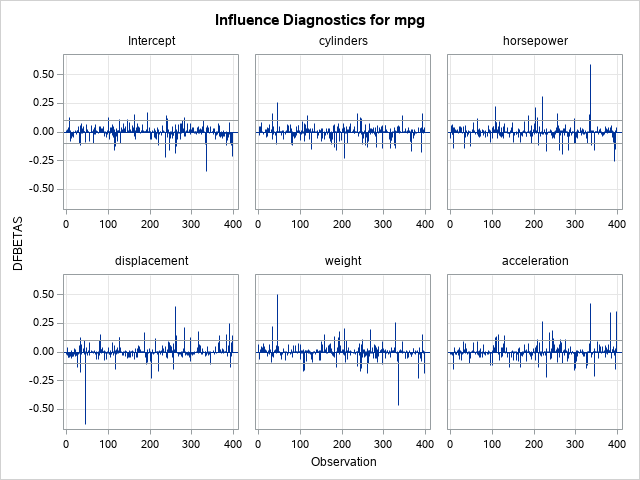
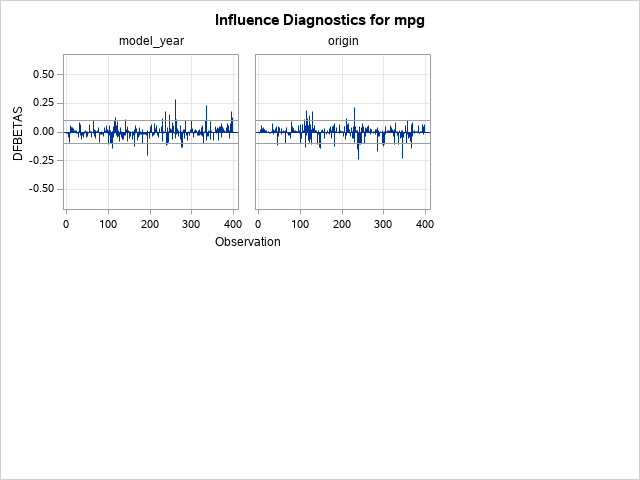
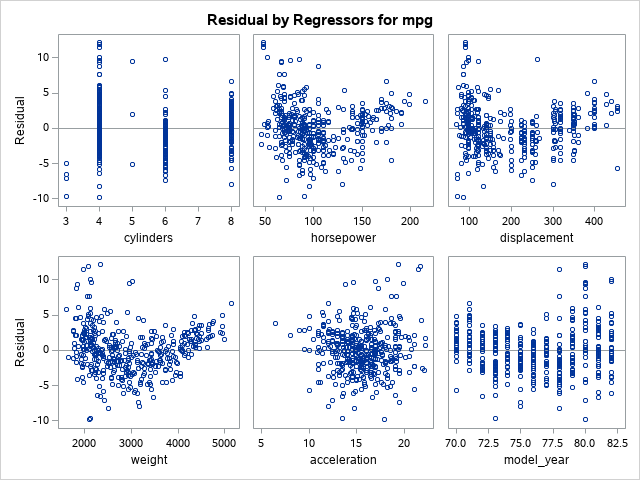
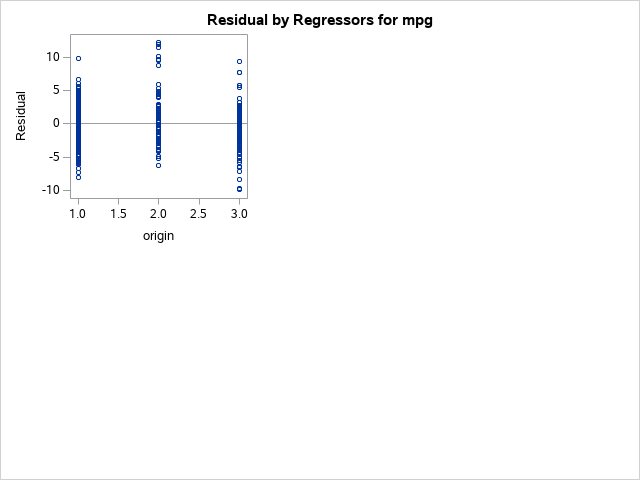

In [32]:
*Using Multiple regression model as below, mpg can be predicted with an accuracy of 81.80%;

proc reg data = auto.log_data plots=all;
    model mpg = cylinders horsepower displacement weight acceleration model_year origin / selection = rsquare cp adjrsq best=4;
run; 
quit;